# Libraries

In [ ]:
!pip install sounddevice
!sudo apt-get install libportaudio2
import pandas as pd
import zipfile
import wave
import os
import sounddevice as sd
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D , MaxPooling1D , Dense , Flatten ,Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from warnings import filters

# Download Dataset

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download dmitrybabko/speech-emotion-recognition-en

speech-emotion-recognition-en.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/speech-emotion-recognition-en.zip -d /content/speech-emotion-recognition-en

# Formatting Dataset

In [ ]:
# Reading The Names Of The Audio Files
folder_path = '/content/speech-emotion-recognition-en/Crema'
emotions = {'ANG': 0, 'SAD': 1, 'HAP': 2, 'FEA': 3, 'DIS': 4, 'NEU': 5}
labels = []
audio_files = []
for f in os.listdir(folder_path):
    if os.path.isfile(os.path.join(folder_path, f)):
        audio_files.append(f)
        labels.append(emotions[f[9: 12]])

In [ ]:
# Playing The Audio Files
for j in range(len(audio_files)):
    file_path = f'/content/speech-emotion-recognition-en/Crema/{audio_files[j]}'
    with open(file_path, "rb") as wav_file:
        audio_data, sample_rate = sf.read(wav_file)
    sd.play(audio_data, sample_rate)
    sd.wait()

In [ ]:
# Plotting The Waveform Of The Audio Files
for j in range(len(audio_files)):
    file_path = f'/content/speech-emotion-recognition-en/Crema/{audio_files[j]}'
    with wave.open(file_path, 'rb') as wav_file:
        # Get the number of frames and sample rate
        num_frames = wav_file.getnframes()
        sample_rate = wav_file.getframerate()
        # Read all the frames into a byte string
        wav_bytes = wav_file.readframes(num_frames)
    # Convert the byte string to a numpy array
    wav_array = np.frombuffer(wav_bytes, dtype='int16')
    # Calculate the duration of the audio file in seconds
    duration = num_frames / float(sample_rate)
    # Generate the time axis for the waveform plot
    time = np.linspace(0, duration, num_frames)
    # Plot the waveform
    # plt.plot(time, wav_array, color='black')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Amplitude')
    # plt.title('Waveform Plot')
    # plt.show()

# Create The Feature Space

In [ ]:
def plot_mel_spectogram(y, sr, zcr, energy, mel_spec_db, hop_length):
    # Zero Crossing Rate
    plt.figure(figsize=(10, 4))
    plt.plot(zcr[0])
    plt.title('Zero Crossing Rate')
    plt.show()
    
    # Energy
    plt.figure(figsize=(10, 4))
    plt.plot(energy)
    plt.title('Energy')
    plt.show()
    
    # Mel Spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.show()

In [ ]:
###adding padding to audio files
audio=[]
max_size=56071
for j in range(len(audio_files)):
    file_path = f'/content/speech-emotion-recognition-en/Crema/{audio_files[j]}'
    y, sr = librosa.load(file_path)
    if len(y) > max_size :
        y = y[:max_size]
    else :
        pad = (max_size - len(y))//2
        y = np.pad(y, ( pad   , max_size - len(y) - pad), 'constant')
    audio.append(y)


In [ ]:
data1D_zcr=[]
data1D_energy=[]
data2D_conv=[]
frame_length = 2048
hop_length = 512
for y in audio:
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    arr_1D = np.hstack((rms,zcr))
    arr_1D = arr_1D.reshape((arr_1D.shape[0], 1))
    data1D_zcr.append(arr_1D)
    
    energy = np.array([sum(abs(y[i : i + frame_length] ** 2)) / frame_length for i in range(0, len(y), frame_length)])
    energy =energy.reshape(energy.shape[0] ,1)
    data1D_energy.append(energy)

    n_fft = 2048
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    mel_spec =mel_spec.reshape((mel_spec.shape[0],mel_spec.shape[1],1))
    data2D_conv.append(mel_spec)
    plot_mel_spectogram(y, sr, zcr, energy, mel_spec_db, hop_length)

# Splitting of The Dataset





In [ ]:
def splitting_data(data , labels):
  x_train,x_test,y_train,y_test = train_test_split(data , labels , random_state= 42  , test_size = 0.3,stratify = labels)
  x_train,x_validation,y_train,y_validation = train_test_split(x_train, y_train , random_state= 42 ,  test_size = 0.05,stratify =y_train)
  return np.array(x_train),np.array(y_train),np.array(x_validation),np.array(y_validation),np.array(x_test),np.array(y_test) 

# Model of Time Domain Feature(zero crossing rate)

In [ ]:
x_train,y_train,x_validation,y_validation,x_test,y_test =splitting_data(data1D_zcr , labels)  #

In [ ]:
print(x_train.shape)
print(x_validation.shape)
print(x_test.shape)
print(y_train.shape)
print(y_validation.shape)
print(y_test.shape)

In [35]:
def arch_model1D(in_shape):
  cnn=keras.Sequential()
  cnn.add(Conv1D(filters=512, kernel_size=5 , strides=1, padding='same', activation="relu", input_shape=in_shape))
  cnn.add(MaxPooling1D(pool_size=5 , strides=2))
  
  cnn.add(Conv1D(filters=512, kernel_size=5, strides=1, padding='same', activation="relu", input_shape=in_shape))
  cnn.add(MaxPooling1D(pool_size= 5 , strides=2))
 
  cnn.add(Conv1D(filters=128, kernel_size=5, strides=1, padding='same', activation="relu", input_shape=in_shape))
  cnn.add(MaxPooling1D(pool_size=5 , strides=2))
 

  cnn.add(Flatten())
  cnn.add(Dense(units=256, activation="relu"))
  cnn.add(Dropout(0.4))
  cnn.add(Dense(units=6, activation="softmax"))
  opt = keras.optimizers.Adam(learning_rate=0.0001)
  cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  cnn.summary()
  return cnn

num_classes = 6   ##number of emotions
y_train = keras.utils.to_categorical(y_train, num_classes)
y_validation = keras.utils.to_categorical(y_validation, num_classes)
cnn_1D=arch_model1D((x_train.shape[1],x_train.shape[2]))

hist = cnn_1D.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=32, epochs=60)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 220, 512)          3072      
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 108, 512)         0         
 g1D)                                                            
                                                                 
 conv1d_31 (Conv1D)          (None, 108, 512)          1311232   
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 52, 512)          0         
 g1D)                                                            
                                                                 
 conv1d_32 (Conv1D)          (None, 52, 128)           327808    
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 24, 128)         

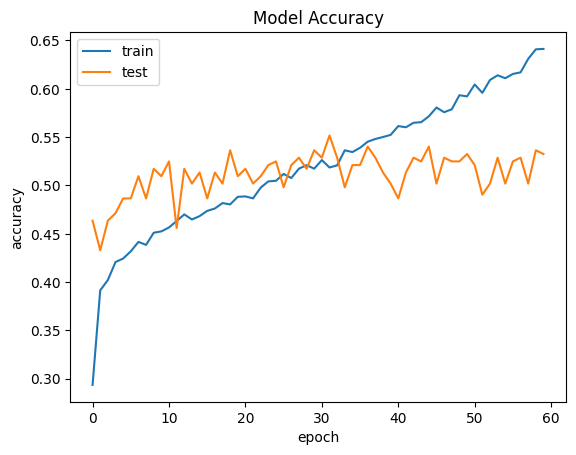

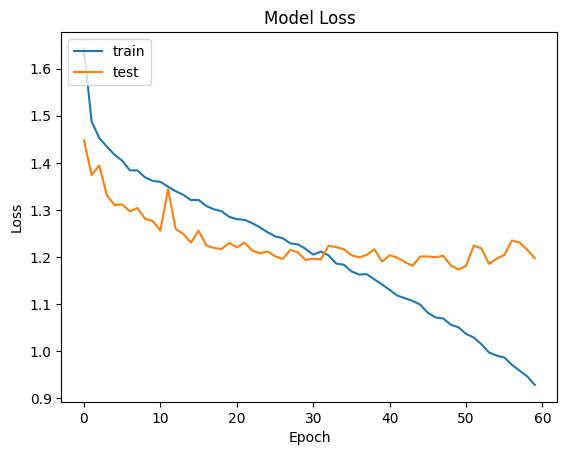

In [36]:
plt.plot(hist.history['accuracy']) 
plt.plot(hist.history['val_accuracy']) 
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Evaluation on CNN Model of 1D

In [37]:
def draw_confusion_matrix(confus_mat):
  fig, ax = plt.subplots(figsize=(6, 6))
  ax.matshow(confus_mat, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(confus_mat.shape[0]):
      for j in range(confus_mat.shape[1]):
          ax.text(x=j, y=i,s=confus_mat[i, j], va='center', ha='center', size='xx-large')
 
  plt.xlabel('Predict', fontsize=14)
  plt.ylabel('True', fontsize=14)
  plt.title('Confusion Matrix', fontsize=16)
  plt.show()


Accuracy of CNN model 1D = 0.5096282958984375 
F1 Score of CNN model 1D = 0.5020600306403878 


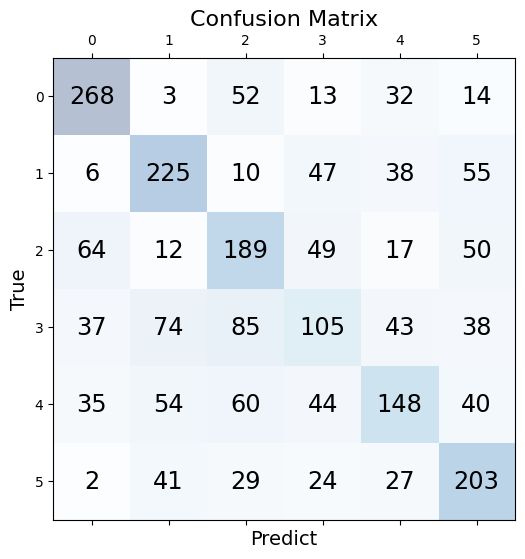

In [38]:
##compute the accuracy
y_test = keras.utils.to_categorical(y_test, 6)
loss, accuracy = cnn_1D.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy of CNN model 1D = {accuracy} ')

# predict test set
y_pred = cnn_1D.predict(x_test, verbose=0)
y_pred_classes=np.argmax(y_pred,axis=1)

##compute the f1 score
y_test=np.argmax(y_test, axis=1)
f1score = f1_score(y_test, y_pred_classes,average='weighted')
print(f'F1 Score of CNN model 1D = {f1score} ')

##drawing the confusion matrix
confus_mat=confusion_matrix(y_test,y_pred_classes)
draw_confusion_matrix(confus_mat)

In [39]:
target_names=['ANG' , 'SAD' , 'HAP' , 'FEA' , 'DIS' , 'NEU']
print(classification_report(y_test, y_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

         ANG       0.65      0.70      0.68       382
         SAD       0.55      0.59      0.57       381
         HAP       0.44      0.50      0.47       381
         FEA       0.37      0.27      0.32       382
         DIS       0.49      0.39      0.43       381
         NEU       0.51      0.62      0.56       326

    accuracy                           0.51      2233
   macro avg       0.50      0.51      0.50      2233
weighted avg       0.50      0.51      0.50      2233



#Model of Spectrogram Feature

In [ ]:
x_train,y_train,x_validation,y_validation,x_test,y_test =splitting_data(data2D_conv , labels)  #

In [ ]:
print(x_train.shape)
print(x_validation.shape)
print(x_test.shape)
print(y_train.shape)
print(y_validation.shape)
print(y_test.shape)

(4948, 128, 110, 1)
(261, 128, 110, 1)
(2233, 128, 110, 1)
(4948,)
(261,)
(2233,)


In [ ]:
def arch_model2D(in_shape):
  model = tf.keras.models.Sequential([
     
      tf.keras.layers.Conv2D(512, (5, 5),padding = 'same', activation = 'relu', input_shape = in_shape),
      tf.keras.layers.MaxPooling2D(pool_size = (5, 5), strides = (2)),
      
      tf.keras.layers.Conv2D(512, (5, 5),padding = 'same', activation = 'relu', input_shape = in_shape),
      tf.keras.layers.MaxPooling2D(pool_size = (5, 5), strides = (2)),
      
      tf.keras.layers.Conv2D(128, (5, 5),padding = 'same', activation = 'relu', input_shape = in_shape),
      tf.keras.layers.MaxPooling2D(pool_size = (5, 5), strides = (2)),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation = 'relu'),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(6, activation = 'softmax') 
  ]) 
  opt = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

num_classes = 6
y_train = keras.utils.to_categorical(y_train, num_classes)
y_validation = keras.utils.to_categorical(y_validation, num_classes)
cnn_2D=arch_model2D((x_train.shape[1],x_train.shape[2], 1))
cnn_2D.summary()

hist = cnn_2D.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=32, epochs=60)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 110, 512)     13312     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 53, 512)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 53, 512)       6554112   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 29, 25, 512)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 25, 128)       1638528   
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 11, 128)     

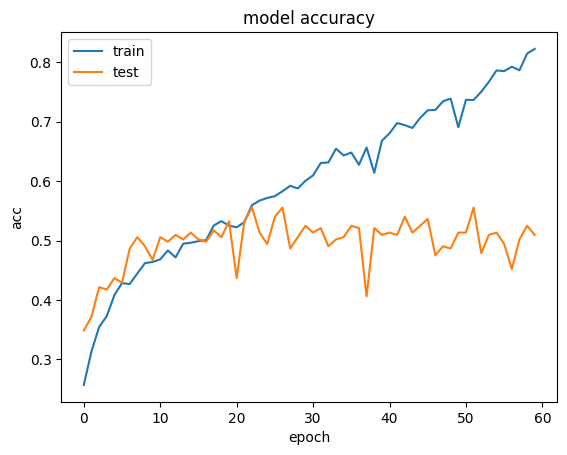

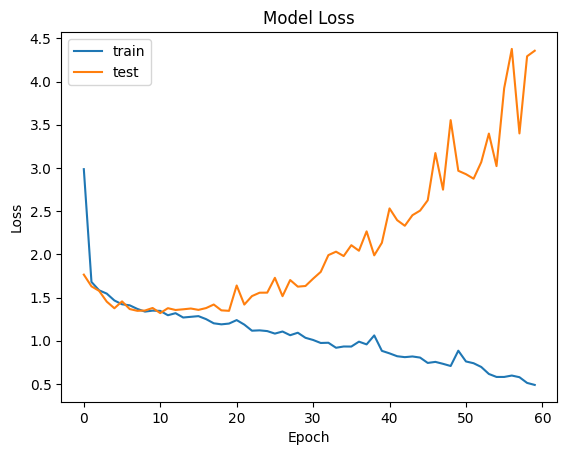

In [ ]:
plt.plot(hist.history['accuracy']) 
plt.plot(hist.history['val_accuracy']) 
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Evaluation of CNN Model of 2-D

Accuracy of CNN model 2D = 0.5123152732849121 
F1 Score of CNN model 2D = 0.5083886528456439 


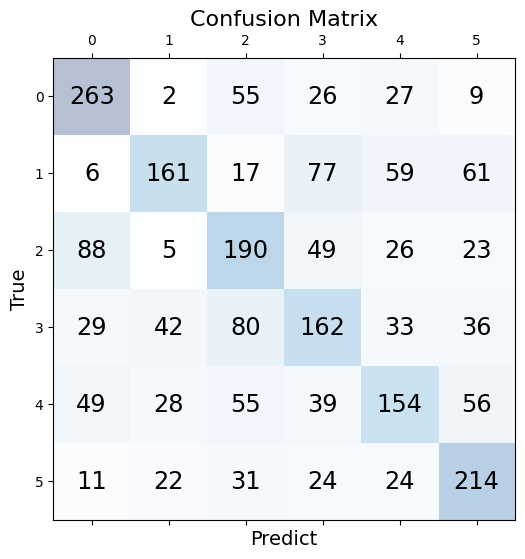

In [ ]:
##compute the accuracy
y_test = keras.utils.to_categorical(y_test, 6)
loss, accuracy = cnn_2D.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy of CNN model 2D = {accuracy} ')

# predict test set
y_pred = cnn_2D.predict(x_test, verbose=0)
y_pred_classes = np.argmax(y_pred,axis=1)

##compute the f1 score
y_test=np.argmax(y_test, axis=1)
f1score = f1_score(y_test, y_pred_classes, average='weighted')
print(f'F1 Score of CNN model 2D = {f1score} ')


###drawing confusion matrix
confus_mat = confusion_matrix(y_test,y_pred_classes)
draw_confusion_matrix(confus_mat)